# <h1> GO/HPO: Scientific Visualization Project

Porcelli Angelica - 78083A

Roveda Gianluca - 73814A

Stefanelli Marta - 84393A

In [1]:
import pandas as pd 

import matplotlib.pyplot as plt
bp = pd.read_csv("gene_go_matrix_propT_rel-is_a-part_of_ont-BP.csv", index_col=0)
cc = pd.read_csv("gene_go_matrix_propT_rel-is_a-part_of_ont-CC.csv", index_col=0)
mf = pd.read_csv("gene_go_matrix_propT_rel-is_a-part_of_ont-MF.csv", index_col=0)


# <h2> 1. Feature Selection

In [2]:
import pandas as pd

def filter_terms_by_frequency(df, min_freq=2, max_prop=0.20, verbose=True):
    """
    Filtra le colonne (termini) di un DataFrame binario gene×term in base alla frequenza.
    
    Args:
      df: pd.DataFrame, righe = geni, colonne = termini; valori 0/1 o booleani
      min_freq: int, soglia minima (es. rimuovi termini con < min_freq geni annotati)
      max_prop: float, proporzione massima (es. rimuovi termini con > max_prop * n_geni)
      verbose: bool, se True stampa le info
    
    Returns:
      df_filtered: DataFrame con solo i termini che passano il filtro
      dropped: dict con liste dei termini rimossi {"rare": [...], "frequent": [...]}
    """

    # Sanity check: converti tutto in 0/1
    df_bin = df.applymap(lambda x: 1 if x not in [0, "0", None, False] else 0)

    n_genes = df_bin.shape[0]
    term_freq = df_bin.sum(axis=0)

    # Calcola soglia max in termini di numero di geni
    max_freq = max_prop * n_genes

    # Identifica i termini da rimuovere
    rare_terms = term_freq[term_freq < min_freq].index.tolist()
    frequent_terms = term_freq[term_freq > max_freq].index.tolist()

    if verbose:
        print(f"Numero geni: {n_genes}")
        print(f"Numero termini originali: {df.shape[1]}")
        print(f"Termini troppo rari (< {min_freq}): {len(rare_terms)}")
        print(f"Termini troppo frequenti (> {max_prop*100:.1f}% = {max_freq:.1f} geni): {len(frequent_terms)}")
        print(f"Totale termini da rimuovere: {len(set(rare_terms + frequent_terms))}")

    # Rimuovi le colonne
    terms_to_drop = set(rare_terms + frequent_terms)
    df_filtered = df_bin.drop(columns=terms_to_drop)

    if verbose:
        print(f"Terminati: rimangono {df_filtered.shape[1]} termini dopo il filtraggio")

    return df_filtered, {"rare": rare_terms, "frequent": frequent_terms}





In [3]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

def jaccard_sparse(a_idx, b_idx):
    inter = len(np.intersect1d(a_idx, b_idx))
    union = len(a_idx) + len(b_idx) - inter
    return inter / union if union > 0 else 0


def remove_redundant_terms_sparse(df, threshold=0.9, size_tol=0.2):
    print("\n=== RIMOZIONE COLONNE RIDONDANTI ===")
    
    # --- 0) Inserisco colonna ID ---
    df = df.copy()
    df.insert(0, 'id', range(1, len(df)+1))
    
    print("Converto in matrice sparse...")
    X = csr_matrix(df.values[:, 1:])  # escludo la colonna id per il calcolo

    cols = df.columns[1:].to_list()  # colonne da confrontare (escludo id)
    nnz = np.diff(X.indptr)

    print("Pre-calcolo indice geni annotati per colonna...")
    col_indices = []
    XT = X.T.tocsr()
    for i in range(X.shape[1]):
        start, end = XT.indptr[i], XT.indptr[i+1]
        col_indices.append(XT.indices[start:end])

    to_drop = set()

    print("Inizio confronto Jaccard (scalabile)...")
    for i in range(len(cols)):
        if cols[i] in to_drop:
            continue

        a_idx = col_indices[i]
        a_size = len(a_idx)

        for j in range(i+1, len(cols)):
            if cols[j] in to_drop:
                continue

            b_idx = col_indices[j]
            b_size = len(b_idx)

            if abs(a_size - b_size) / max(a_size, b_size) > size_tol:
                continue

            jac = jaccard_sparse(a_idx, b_idx)
            if jac >= threshold:
                to_drop.add(cols[j])

        if i % 200 == 0:
            print(f"  → Processate {i}/{len(cols)} colonne...")

    print(f"Colonne ridondanti trovate: {len(to_drop)}")
    print(f"Colonne finali: {len(cols) - len(to_drop)}")

    # --- Rimuovo colonne ridondanti ---
    df_clean = df.drop(columns=list(to_drop))
    
    # --- Rimuovo righe tutte zero (escludendo la colonna id) ---
    empty_rows = (df_clean.iloc[:, 1:] == 0).all(axis=1)
    n_empty = empty_rows.sum()
    if n_empty > 0:
        print(f"Rimuovo {n_empty} righe totalmente vuote (escludendo id)")
        df_clean = df_clean.loc[~empty_rows]

    return df_clean


In [4]:
bp_filtered, dropped = filter_terms_by_frequency(bp, min_freq=3, max_prop=0.20)
bp_no_redundancy = remove_redundant_terms_sparse(bp_filtered, threshold=0.9)

mf_filtered, dropped = filter_terms_by_frequency(mf, min_freq=3, max_prop=0.20)
mf_no_redundancy = remove_redundant_terms_sparse(mf_filtered, threshold=0.9)

cc_filtered, dropped = filter_terms_by_frequency(cc, min_freq=3, max_prop=0.20)
cc_no_redundancy = remove_redundant_terms_sparse(cc_filtered, threshold=0.9)

# Ottieni gli ID comuni
common_ids = set(bp_no_redundancy['id']) & set(mf_no_redundancy['id']) & set(cc_no_redundancy['id'])
print(f"Righe comuni in tutte le tabelle: {len(common_ids)}")

# Filtra le tabelle usando solo gli ID comuni
bp_final = bp_no_redundancy[bp_no_redundancy['id'].isin(common_ids)].copy()
mf_final = mf_no_redundancy[mf_no_redundancy['id'].isin(common_ids)].copy()
cc_final = cc_no_redundancy[cc_no_redundancy['id'].isin(common_ids)].copy()

# (opzionale) riordina per id
bp_final.sort_values('id', inplace=True)
mf_final.sort_values('id', inplace=True)
cc_final.sort_values('id', inplace=True)

# Resetta gli indici
bp_final.reset_index(drop=True, inplace=True)
mf_final.reset_index(drop=True, inplace=True)
cc_final.reset_index(drop=True, inplace=True)

C:\Users\Angelica\AppData\Local\Temp\ipykernel_21820\1832627117.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bin = df.applymap(lambda x: 1 if x not in [0, "0", None, False] else 0)


Numero geni: 5183
Numero termini originali: 9873
Termini troppo rari (< 3): 3461
Termini troppo frequenti (> 20.0% = 1036.6 geni): 26
Totale termini da rimuovere: 3487
Terminati: rimangono 6386 termini dopo il filtraggio

=== RIMOZIONE COLONNE RIDONDANTI ===
Converto in matrice sparse...
Pre-calcolo indice geni annotati per colonna...
Inizio confronto Jaccard (scalabile)...
  → Processate 0/6386 colonne...
  → Processate 200/6386 colonne...
  → Processate 400/6386 colonne...
  → Processate 600/6386 colonne...
  → Processate 800/6386 colonne...
  → Processate 1000/6386 colonne...
  → Processate 1200/6386 colonne...
  → Processate 1400/6386 colonne...
  → Processate 1600/6386 colonne...
  → Processate 1800/6386 colonne...
  → Processate 2000/6386 colonne...
  → Processate 2200/6386 colonne...
  → Processate 2400/6386 colonne...
  → Processate 2600/6386 colonne...
  → Processate 2800/6386 colonne...
  → Processate 3000/6386 colonne...
  → Processate 3200/6386 colonne...
  → Processate 340

C:\Users\Angelica\AppData\Local\Temp\ipykernel_21820\1832627117.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bin = df.applymap(lambda x: 1 if x not in [0, "0", None, False] else 0)


Numero geni: 5183
Numero termini originali: 3258
Termini troppo rari (< 3): 1843
Termini troppo frequenti (> 20.0% = 1036.6 geni): 8
Totale termini da rimuovere: 1851
Terminati: rimangono 1407 termini dopo il filtraggio

=== RIMOZIONE COLONNE RIDONDANTI ===
Converto in matrice sparse...
Pre-calcolo indice geni annotati per colonna...
Inizio confronto Jaccard (scalabile)...
  → Processate 0/1407 colonne...
  → Processate 200/1407 colonne...
  → Processate 400/1407 colonne...
  → Processate 600/1407 colonne...
  → Processate 800/1407 colonne...
  → Processate 1000/1407 colonne...
  → Processate 1200/1407 colonne...
  → Processate 1400/1407 colonne...
Colonne ridondanti trovate: 70
Colonne finali: 1337
Rimuovo 569 righe totalmente vuote (escludendo id)


C:\Users\Angelica\AppData\Local\Temp\ipykernel_21820\1832627117.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bin = df.applymap(lambda x: 1 if x not in [0, "0", None, False] else 0)


Numero geni: 5183
Numero termini originali: 1478
Termini troppo rari (< 3): 526
Termini troppo frequenti (> 20.0% = 1036.6 geni): 21
Totale termini da rimuovere: 547
Terminati: rimangono 931 termini dopo il filtraggio

=== RIMOZIONE COLONNE RIDONDANTI ===
Converto in matrice sparse...
Pre-calcolo indice geni annotati per colonna...
Inizio confronto Jaccard (scalabile)...
  → Processate 0/931 colonne...
  → Processate 200/931 colonne...
  → Processate 400/931 colonne...
  → Processate 600/931 colonne...
  → Processate 800/931 colonne...
Colonne ridondanti trovate: 49
Colonne finali: 882
Rimuovo 539 righe totalmente vuote (escludendo id)
Righe comuni in tutte le tabelle: 4166


# <h2> 2. Jaccard Function

In [5]:
import numpy as np
import pandas as pd
import pyopencl as cl

# =====================================================================================
# Kernel OpenCL per Jaccard (stabile su Intel Iris Xe)
# =====================================================================================
kernel_code = """
__kernel void jaccard(
    __global const int *mat,
    __global float *out,
    const int n_rows,
    const int n_cols,
    const int row_offset
){
    int i = get_global_id(0) + row_offset;
    int j = get_global_id(1);

    if (i >= n_rows || j >= n_rows)
        return;

    int intersection = 0;
    int uni = 0;

    for (int k = 0; k < n_cols; k++){
        int a = mat[i*n_cols + k];
        int b = mat[j*n_cols + k];

        if (a == 1 || b == 1)
            uni++;

        if (a == 1 && b == 1)
            intersection++;
    }

    if (uni == 0)
        out[i*n_rows + j] = 0.0f;
    else
        out[i*n_rows + j] = (float)intersection / (float)uni;
}
"""

# =====================================================================================
# Funzione Jaccard con CHUNKING ottimizzata per Intel GPU
# =====================================================================================
def jaccard_opencl_intel(df, CHUNK=128):
    """
    Calcola la Jaccard similarity su GPU Intel Iris Xe con chunking,
    evitando di saturare la GPU e senza freeze dello schermo.
    """
    # --- converti la matrice in int32 ---
    X = df.values.astype(np.int32)
    n_rows, n_cols = X.shape

    # --- crea contesto OpenCL (Intel GPU se disponibile) ---
    try:
        platforms = cl.get_platforms()
        gpu_devices = []
        for p in platforms:
            for d in p.get_devices(device_type=cl.device_type.GPU):
                gpu_devices.append(d)

        if len(gpu_devices) == 0:
            raise RuntimeError("No GPU found. Using CPU OpenCL.")

        ctx = cl.Context(devices=[gpu_devices[0]])
    except:
        # fallback: CPU
        ctx = cl.create_some_context()

    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags

    # --- prepara buffer GPU ---
    X_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=X)
    out_buf = cl.Buffer(ctx, mf.WRITE_ONLY, size=n_rows * n_rows * 4)

    # --- build kernel ---
    prg = cl.Program(ctx, kernel_code).build()
    kern = cl.Kernel(prg, "jaccard")

    # --- matrice risultato CPU ---
    result = np.zeros((n_rows, n_rows), dtype=np.float32)

    # --- calcolo in chunks ---
    for start in range(0, n_rows, CHUNK):
        h = min(CHUNK, n_rows - start)

        kern.set_args(
            X_buf, out_buf,
            np.int32(n_rows),
            np.int32(n_cols),
            np.int32(start)
        )

        # Work size = (h, n_rows)
        cl.enqueue_nd_range_kernel(
            queue, kern,
            (h, n_rows),  # non saturante su Intel Iris Xe
            None
        )

        # copia il risultato parziale
        cl.enqueue_copy(queue, result, out_buf)

    return pd.DataFrame(result, index=df.index, columns=df.index)


In [6]:
S_bp  = jaccard_opencl_intel(bp_final,  CHUNK=128)
S_mf = jaccard_opencl_intel(mf_final, CHUNK=128)
S_cc  = jaccard_opencl_intel(cc_final,  CHUNK=128)

# <h2> 3. TF - IDF

In [7]:
import numpy as np
from scipy.sparse import csr_matrix

def apply_tfidf(df):
    """
    Applica TF-IDF a una matrice binaria GO/HPO mantenendo formato sparso.
    Stampa messaggi di feedback durante l'esecuzione.
    """
    print("=== STEP C: TF-IDF sui termini ===")

    # Conversione in sparse
    print("→ Converto il DataFrame in matrice sparse CSR...")
    X = csr_matrix(df.values)
    n_genes, n_terms = X.shape
    print(f"   Matrice: {n_genes} geni × {n_terms} termini")

    # Calcolo frequenza dei termini (df_j)
    print("→ Calcolo la frequenza (df_j) dei termini...")
    df_j = np.array(X.sum(axis=0)).ravel()
    print("   Fatto. Esempio frequenze:")
    print("   - min:", df_j.min(), " max:", df_j.max(), " median:", np.median(df_j))

    # Calcolo IDF
    print("→ Calcolo IDF = log(N / df_j)...")
    idf = np.log(n_genes / df_j)
    print("   Fatto. Esempio valori IDF:")
    print("   - min:", idf.min(), " max:", idf.max(), " median:", np.median(idf))

    # Applica TF-IDF
    print("→ Applico i pesi TF-IDF alle colonne (sparse-safe)...")
    X_tfidf = X.multiply(idf)
    print("   Fatto. La matrice finale è ancora sparse.")
    print(f"   Formato: {X_tfidf.shape}, non-zero entries: {X_tfidf.nnz}")

    print("=== TF-IDF COMPLETATO ===\n")

    return X_tfidf, idf


In [8]:

# --- Step 1: TF-IDF sui tre dataset ---
from scipy.sparse import csr_matrix

X_bp_tfidf, idf_bp = apply_tfidf(bp_final)
X_mf_tfidf, idf_mf = apply_tfidf(mf_final)
X_cc_tfidf, idf_cc = apply_tfidf(cc_final)

# Conversione: SNF richiede dense float32
bp_dense = X_bp_tfidf.toarray().astype(np.float32)
mf_dense = X_mf_tfidf.toarray().astype(np.float32)
cc_dense = X_cc_tfidf.toarray().astype(np.float32)

# --- Step 2: Affinities ---
from snf import make_affinity

A_bp = make_affinity(bp_dense, K=20)
A_mf = make_affinity(mf_dense, K=20)
A_cc = make_affinity(cc_dense, K=20)


=== STEP C: TF-IDF sui termini ===
→ Converto il DataFrame in matrice sparse CSR...
   Matrice: 4166 geni × 6120 termini
→ Calcolo la frequenza (df_j) dei termini...
   Fatto. Esempio frequenze:
   - min: 0  max: 9984115  median: 9.0
→ Calcolo IDF = log(N / df_j)...
   Fatto. Esempio valori IDF:
   - min: -7.78179426613358  max: inf  median: 6.137487044484698
→ Applico i pesi TF-IDF alle colonne (sparse-safe)...
   Fatto. La matrice finale è ancora sparse.
   Formato: (4166, 6120), non-zero entries: 190668
=== TF-IDF COMPLETATO ===

=== STEP C: TF-IDF sui termini ===
→ Converto il DataFrame in matrice sparse CSR...
   Matrice: 4166 geni × 1338 termini
→ Calcolo la frequenza (df_j) dei termini...
   Fatto. Esempio frequenze:
   - min: 0  max: 9984115  median: 7.0
→ Calcolo IDF = log(N / df_j)...
   Fatto. Esempio valori IDF:
   - min: -7.78179426613358  max: inf  median: 6.3888014727656035
→ Applico i pesi TF-IDF alle colonne (sparse-safe)...
   Fatto. La matrice finale è ancora sparse.

C:\Users\Angelica\AppData\Local\Temp\ipykernel_21820\2351736147.py:25: RuntimeWarning: divide by zero encountered in divide
  idf = np.log(n_genes / df_j)
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was rena

# <h2> 5. Similar Network Function - SNF

In [9]:
from snf import snf
W_fused = snf([A_bp, A_mf, A_cc], K=20, t=10)

c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# <h2> 6. HDBSCAN & UMAP Clustering

c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


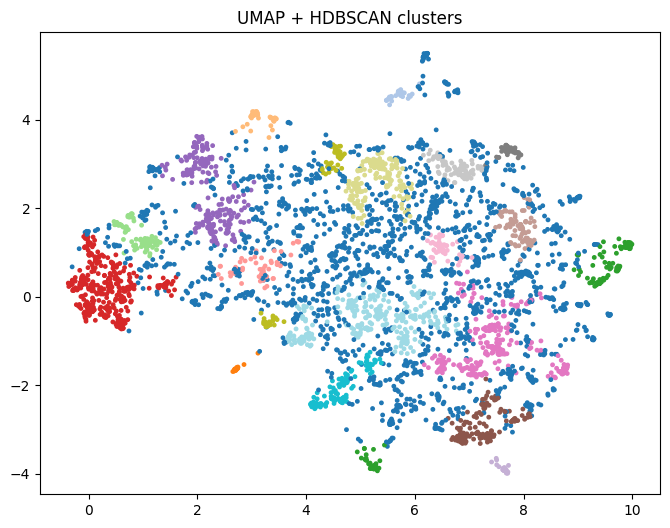

In [10]:
import umap
import numpy as np
import umap.umap_ as umap

# UMAP with cosine distance (usually best for similarity networks)
umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

embedding = umap_model.fit_transform(W_fused)

import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    metric="euclidean"
)

labels = clusterer.fit_predict(embedding)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:,0], embedding[:,1],
            c=labels,
            cmap='tab20',
            s=6)
plt.title("UMAP + HDBSCAN clusters")
plt.show()

In [47]:
import plotly.graph_objects as go
import numpy as np

def plot_network_plotly(W_fused, threshold=0.8):
    # soglia
    W = W_fused.copy()
    W[W < threshold] = 0
    
    n = W.shape[0]

    # nodi
    node_x = np.random.randn(n)
    node_y = np.random.randn(n)

    edge_x = []
    edge_y = []

    # edges
    for i in range(n):
        for j in range(i+1, n):
            if W[i,j] > 0:
                edge_x += [node_x[i], node_x[j], None]
                edge_y += [node_y[i], node_y[j], None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        mode='lines',
        line=dict(width=0.5, color='gray'),
        hoverinfo='none'
    )

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        marker=dict(size=5, color='blue'),
        hoverinfo='text'
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f"Network from W_fused (threshold={threshold})",
                        showlegend=False,
                        hovermode='closest',
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))

    fig.show()

plot_network_plotly(W_fused, threshold=0.8)


In [11]:
import umap
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


def umap_hdbscan_from_affinity(W_fused, gene_labels=None,
                               n_neighbors=30, min_dist=0.1,
                               metric="cosine", random_state=42,
                               interactive=True):
    """
    UMAP + HDBSCAN applicato a una matrice di affinità già fusa (W_fused).
    
    Argomenti:
        W_fused: matrice (n_geni × n_geni) ottenuta da SNF
        gene_labels: annotazioni opzionali (nomi geni) per hover
        n_neighbors, min_dist: parametri UMAP
        metric: metrica UMAP (default: cosine)
        interactive: se True → plot Plotly, altrimenti Matplotlib
        
    Ritorna:
        embedding: (n_geni × 2)
        cluster_labels: etichette HDBSCAN
    """

    print("=== STEP D: UMAP embedding + HDBSCAN clustering (da W_fused) ===")
    print(f"Input: matrice fusa {W_fused.shape[0]} × {W_fused.shape[1]}")
    
    # --- UMAP ---
    print(f"→ Configuro UMAP: n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}")
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )

    print("→ Fit e trasformazione UMAP su W_fused...")
    embedding = reducer.fit_transform(W_fused)
    print(f"   Embedding shape: {embedding.shape}")
    
    # --- HDBSCAN ---
    print("→ Eseguo HDBSCAN sullo spazio UMAP...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=30, metric='euclidean')
    cluster_labels = clusterer.fit_predict(embedding)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    print(f"   Cluster trovati: {n_clusters}, punti noise: {n_noise}")
    
    # --- Plot ---
    if interactive:
        print("→ Creo plot interattivo con Plotly...")
        df_plot = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Cluster': cluster_labels.astype(str)
        })
        if gene_labels is not None:
            df_plot['Gene'] = gene_labels
        
        fig = px.scatter(
            df_plot, x='UMAP1', y='UMAP2',
            color='Cluster',
            hover_data=['Gene'] if gene_labels is not None else None,
            title='UMAP + HDBSCAN (da W_fused)',
            width=800, height=600
        )
        fig.show()
    else:
        print("→ Creo plot statico con Matplotlib...")
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                              c=cluster_labels, cmap='tab20',
                              s=10, alpha=0.8)
        plt.title("UMAP + HDBSCAN (da W_fused)")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.colorbar(scatter, label='Cluster')
        plt.grid(True)
        plt.show()
    
    print("=== PIPELINE COMPLETATA ===\n")

    return embedding, cluster_labels


In [12]:
embedding, labels = umap_hdbscan_from_affinity(
    W_fused,
    gene_labels=bp_final['id'],   # opzionale
    interactive=True              # oppure False
)

=== STEP D: UMAP embedding + HDBSCAN clustering (da W_fused) ===
Input: matrice fusa 4166 × 4166
→ Configuro UMAP: n_neighbors=30, min_dist=0.1, metric=cosine
→ Fit e trasformazione UMAP su W_fused...


c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   Embedding shape: (4166, 2)
→ Eseguo HDBSCAN sullo spazio UMAP...
   Cluster trovati: 25, punti noise: 1769
→ Creo plot interattivo con Plotly...


c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


=== PIPELINE COMPLETATA ===



# <h2> 7. Cluster Analysis

In [13]:
# --- 7) Salva gene -> cluster ---
gene_cluster_df = pd.DataFrame({
    'gene_id': bp_final['id'],   # assumendo che l'id sia lo stesso per tutti e tre i domini
    'cluster': labels
})
gene_cluster_df.to_csv("gene_cluster.csv", index=False)
print("File gene_cluster.csv salvato.")

# --- 8) Funzione top-5 termini per cluster ---
def top_terms_per_cluster(X_tfidf, labels, term_names, top_k=5):
    unique_clusters = sorted([c for c in set(labels) if c != -1])
    result = {}
    X = X_tfidf.tocsr()
    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        if len(idx) == 0:
            continue
        cluster_mean = X[idx].mean(axis=0).A1
        top_idx = np.argsort(cluster_mean)[::-1][:top_k]
        terms = [(term_names[i], cluster_mean[i]) for i in top_idx]
        result[c] = terms
    return result

# --- 9) Top 5 termini per cluster per dominio ---
domains = {'BP': (X_bp_tfidf, bp_final.columns),
           'MF': (X_mf_tfidf, mf_final.columns),
           'CC': (X_cc_tfidf, cc_final.columns)}

for dom, (X_tfidf, cols) in domains.items():
    print(f"\n=== Top 5 termini per cluster - {dom} ===")
    top5 = top_terms_per_cluster(X_tfidf, labels, cols, top_k=5)
    for c, terms in top5.items():
        print(f"\nCluster {c}:")
        for t, score in terms:
            print(f"  {t} → {score:.4f}")

File gene_cluster.csv salvato.

=== Top 5 termini per cluster - BP ===

Cluster 0:
  GO.0006120 → 4.2788
  GO.0015986 → 3.9989
  GO.0006754 → 3.8521
  GO.0042775 → 3.8399
  GO.0032981 → 3.7884

Cluster 1:
  GO.0022900 → 2.8993
  GO.0022904 → 2.8945
  GO.0006119 → 2.8645
  GO.0042775 → 2.8573
  GO.0009060 → 2.7190

Cluster 2:
  GO.0007018 → 3.1705
  GO.0003341 → 3.0831
  GO.0060271 → 2.8182
  GO.0007017 → 2.6652
  GO.0030031 → 2.5969

Cluster 3:
  GO.0006412 → 3.0461
  GO.0002181 → 2.5371
  GO.0042254 → 2.1209
  GO.0010467 → 1.6982
  GO.0042274 → 1.6597

Cluster 4:
  GO.0045109 → 3.1492
  GO.0045104 → 3.0965
  GO.0031424 → 2.2966
  GO.0030216 → 2.2125
  GO.0043588 → 2.0154

Cluster 5:
  GO.0030001 → 2.3836
  GO.0098655 → 2.3324
  GO.0006812 → 2.2114
  GO.0034220 → 2.1869
  GO.0006811 → 2.0830

Cluster 6:
  GO.0006325 → 2.3206
  GO.0006338 → 2.2862
  GO.0006357 → 1.3279
  GO.0034728 → 1.1741
  GO.0045892 → 1.1240

Cluster 7:
  GO.0006357 → 1.5812
  GO.0045944 → 1.3980
  GO.0045893 → 1.34

# <h3> Cluster Size

In [14]:
np.unique(labels, return_counts=True)


(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24]),
 array([1769,   33,   34,   32,   51,   42,  109,   86,  350,   50,  119,
         129,   33,  137,   85,   49,  214,   55,   48,   86,   30,   45,
         162,  126,   58,  234]))

In [15]:
import numpy as np
import pandas as pd

clusters, counts = np.unique(labels, return_counts=True)
total = counts.sum()

df = pd.DataFrame({
    "cluster": clusters,
    "n_genes": counts,
    "percent": (counts / total) * 100
})

print(df)


    cluster  n_genes    percent
0        -1     1769  42.462794
1         0       33   0.792127
2         1       34   0.816131
3         2       32   0.768123
4         3       51   1.224196
5         4       42   1.008161
6         5      109   2.616419
7         6       86   2.064330
8         7      350   8.401344
9         8       50   1.200192
10        9      119   2.856457
11       10      129   3.096495
12       11       33   0.792127
13       12      137   3.288526
14       13       85   2.040326
15       14       49   1.176188
16       15      214   5.136822
17       16       55   1.320211
18       17       48   1.152184
19       18       86   2.064330
20       19       30   0.720115
21       20       45   1.080173
22       21      162   3.888622
23       22      126   3.024484
24       23       58   1.392223
25       24      234   5.616899


In [16]:
import numpy as np
import pandas as pd

mask = labels != -1
clusters, counts = np.unique(labels[mask], return_counts=True)
total = counts.sum()

df = pd.DataFrame({
    "cluster": clusters,
    "n_genes": counts,
    "percent": (counts / total) * 100
})

print(df)


    cluster  n_genes    percent
0         0       33   1.376721
1         1       34   1.418440
2         2       32   1.335002
3         3       51   2.127660
4         4       42   1.752190
5         5      109   4.547351
6         6       86   3.587818
7         7      350  14.601585
8         8       50   2.085941
9         9      119   4.964539
10       10      129   5.381727
11       11       33   1.376721
12       12      137   5.715478
13       13       85   3.546099
14       14       49   2.044222
15       15      214   8.927826
16       16       55   2.294535
17       17       48   2.002503
18       18       86   3.587818
19       19       30   1.251564
20       20       45   1.877347
21       21      162   6.758448
22       22      126   5.256571
23       23       58   2.419691
24       24      234   9.762203


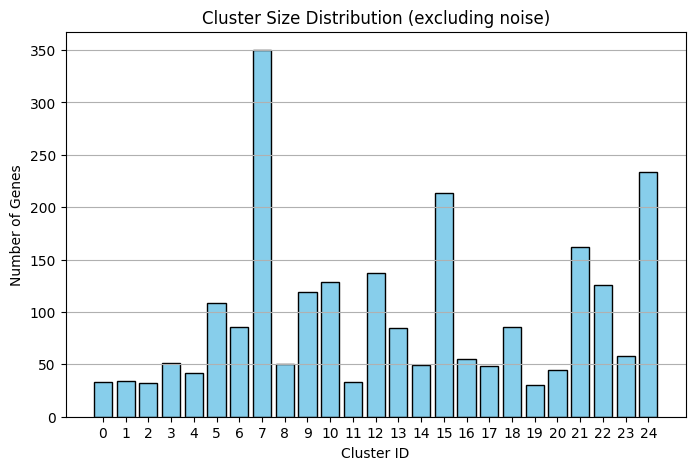

In [17]:
#grafico cluster size distribution
import matplotlib.pyplot as plt

def plot_cluster_size_distribution(labels):
    mask = labels != -1
    clusters, counts = np.unique(labels[mask], return_counts=True)

    plt.figure(figsize=(8, 5))
    plt.bar(clusters, counts, color='skyblue', edgecolor='black')
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Genes")
    plt.title("Cluster Size Distribution (excluding noise)")
    plt.xticks(clusters)
    plt.grid(axis='y')
    plt.show()
plot_cluster_size_distribution(labels)

# <h2> 8. Final Analysis Centroids

In [18]:
import numpy as np
import pandas as pd

def compute_cluster_centroids(X_tfidf, labels, term_names):
    """
    Calcola i centroidi TF-IDF di ogni cluster.

    Args:
        X_tfidf: matrice sparse CSR (geni × termini)
        labels: vettore etichette cluster HDBSCAN
        term_names: nomi delle colonne (termini GO)

    Ritorna:
        dict: cluster_id -> DataFrame (termine, valore_centroide)
    """
    X = X_tfidf.tocsr()
    unique_clusters = sorted([c for c in set(labels) if c != -1])
    centroids = {}

    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        if len(idx) == 0:
            continue

        centroid_vec = X[idx].mean(axis=0).A1  # media sulle righe del cluster
        df = pd.DataFrame({
            'term': term_names,
            'centroid_value': centroid_vec
        }).sort_values(by='centroid_value', ascending=False)

        centroids[c] = df.reset_index(drop=True)

    return centroids


In [19]:
centroids_BP = compute_cluster_centroids(X_bp_tfidf, labels, bp_final.columns)
centroids_MF = compute_cluster_centroids(X_mf_tfidf, labels, mf_final.columns)
centroids_CC = compute_cluster_centroids(X_cc_tfidf, labels, cc_final.columns)


In [20]:
for c, df in centroids_BP.items():
    print(f"\n=== Cluster {c} — Centroide BP ===")
    print(df.head(1))



=== Cluster 0 — Centroide BP ===
         term  centroid_value
0  GO.0006120        4.278797

=== Cluster 1 — Centroide BP ===
         term  centroid_value
0  GO.0022900        2.899319

=== Cluster 2 — Centroide BP ===
         term  centroid_value
0  GO.0007018        3.170452

=== Cluster 3 — Centroide BP ===
         term  centroid_value
0  GO.0006412        3.046086

=== Cluster 4 — Centroide BP ===
         term  centroid_value
0  GO.0045109        3.149196

=== Cluster 5 — Centroide BP ===
         term  centroid_value
0  GO.0030001        2.383586

=== Cluster 6 — Centroide BP ===
         term  centroid_value
0  GO.0006325        2.320561

=== Cluster 7 — Centroide BP ===
         term  centroid_value
0  GO.0006357        1.581165

=== Cluster 8 — Centroide BP ===
         term  centroid_value
0  GO.0016567        2.159262

=== Cluster 9 — Centroide BP ===
         term  centroid_value
0  GO.0006396        2.323378

=== Cluster 10 — Centroide BP ===
         term  centroid_v

In [21]:
for c, df in centroids_MF.items():
    print(f"\n=== Cluster {c} — Centroide MF ===")
    print(df.head(1))

for c, df in centroids_CC.items():
    print(f"\n=== Cluster {c} — Centroide CC ===")
    print(df.head(1))



=== Cluster 0 — Centroide MF ===
         term  centroid_value
0  GO.0008137        4.335513

=== Cluster 1 — Centroide MF ===
         term  centroid_value
0  GO.0009055        2.355281

=== Cluster 2 — Centroide MF ===
         term  centroid_value
0  GO.0045505        2.695136

=== Cluster 3 — Centroide MF ===
         term  centroid_value
0  GO.0003735        3.715034

=== Cluster 4 — Centroide MF ===
         term  centroid_value
0  GO.0030280        2.310117

=== Cluster 5 — Centroide MF ===
         term  centroid_value
0  GO.0005261        2.830469

=== Cluster 6 — Centroide MF ===
         term  centroid_value
0  GO.0003712        1.620141

=== Cluster 7 — Centroide MF ===
         term  centroid_value
0  GO.0000981        2.085814

=== Cluster 8 — Centroide MF ===
         term  centroid_value
0  GO.0004842        1.457263

=== Cluster 9 — Centroide MF ===
         term  centroid_value
0  GO.0003723        2.048221

=== Cluster 10 — Centroide MF ===
         term  centroid_v

In [22]:
df_plot = pd.DataFrame({
    "UMAP1": embedding[:,0],
    "UMAP2": embedding[:,1],
    "cluster": labels
})
df_plot.to_csv("umap_clusters.csv", index=False)


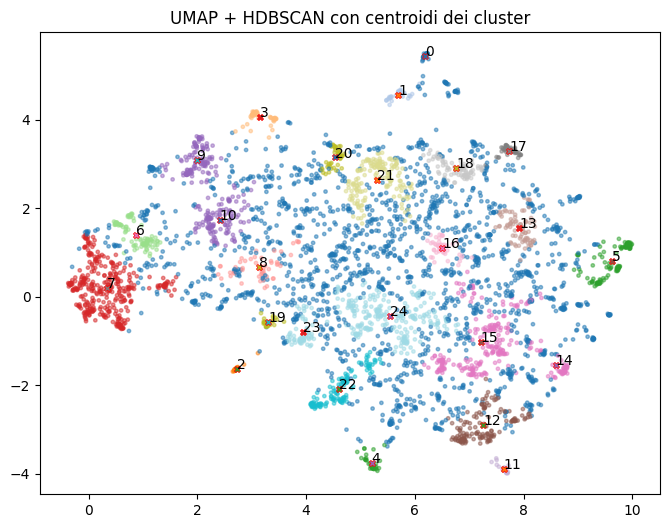

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_centroids(embedding, labels):
    unique_clusters = [c for c in np.unique(labels) if c != -1]

    plt.figure(figsize=(8, 6))

    # scatter dei punti
    plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap="tab20", s=6, alpha=0.5)

    # centroidi
    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        centroid = embedding[idx].mean(axis=0)

        plt.scatter(centroid[0], centroid[1], 
                    s=20, marker="X", edgecolors="red", linewidth=0.5)
        plt.text(centroid[0], centroid[1], str(c), fontsize=10)

    plt.title("UMAP + HDBSCAN con centroidi dei cluster")
    plt.show()
plot_centroids(embedding, labels)

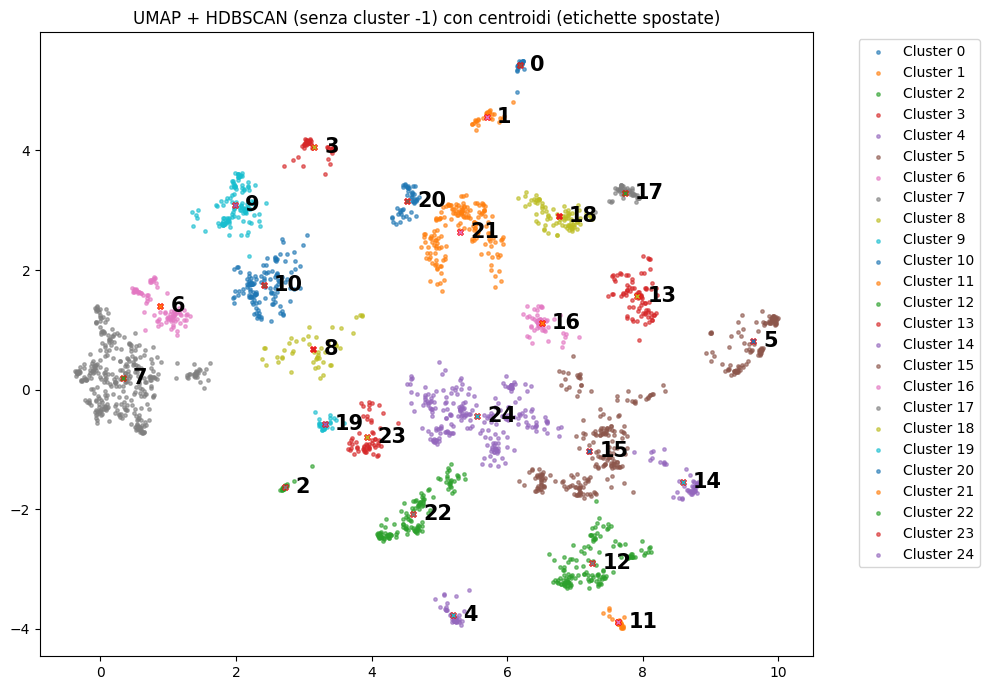

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_centroids_no_noise_offset(embedding, labels, offset=0.15):
    # cluster validi
    unique_clusters = [c for c in np.unique(labels) if c != -1]

    plt.figure(figsize=(10, 7))

    # scatter dei punti (solo cluster validi)
    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        plt.scatter(
            embedding[idx, 0], embedding[idx, 1],
            s=6, alpha=0.6,
            label=f"Cluster {c}"
        )

    # centroidi + etichette spostate
    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        centroid = embedding[idx].mean(axis=0)

        # marker del centroide
        plt.scatter(
            centroid[0], centroid[1],
            s=20, marker="X", edgecolors="red", linewidth=0.5
        )

        # etichetta spostata leggermente a destra
        plt.text(
            centroid[0] + offset,
            centroid[1],
            str(c),
            fontsize=15, weight="bold",
            ha='left', va='center'
        )

    plt.title("UMAP + HDBSCAN (senza cluster -1) con centroidi (etichette spostate)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # legenda a lato
    plt.tight_layout()
    plt.show()

plot_centroids_no_noise_offset(embedding, labels)



# <h3> Cluster Size

In [25]:
np.unique(labels, return_counts=True)


(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24]),
 array([1769,   33,   34,   32,   51,   42,  109,   86,  350,   50,  119,
         129,   33,  137,   85,   49,  214,   55,   48,   86,   30,   45,
         162,  126,   58,  234]))

In [26]:
import numpy as np
import pandas as pd

clusters, counts = np.unique(labels, return_counts=True)
total = counts.sum()

df = pd.DataFrame({
    "cluster": clusters,
    "n_genes": counts,
    "percent": (counts / total) * 100
})

print(df)


    cluster  n_genes    percent
0        -1     1769  42.462794
1         0       33   0.792127
2         1       34   0.816131
3         2       32   0.768123
4         3       51   1.224196
5         4       42   1.008161
6         5      109   2.616419
7         6       86   2.064330
8         7      350   8.401344
9         8       50   1.200192
10        9      119   2.856457
11       10      129   3.096495
12       11       33   0.792127
13       12      137   3.288526
14       13       85   2.040326
15       14       49   1.176188
16       15      214   5.136822
17       16       55   1.320211
18       17       48   1.152184
19       18       86   2.064330
20       19       30   0.720115
21       20       45   1.080173
22       21      162   3.888622
23       22      126   3.024484
24       23       58   1.392223
25       24      234   5.616899


In [27]:
import numpy as np
import pandas as pd

mask = labels != -1
clusters, counts = np.unique(labels[mask], return_counts=True)
total = counts.sum()

df = pd.DataFrame({
    "cluster": clusters,
    "n_genes": counts,
    "percent": (counts / total) * 100
})

print(df)


    cluster  n_genes    percent
0         0       33   1.376721
1         1       34   1.418440
2         2       32   1.335002
3         3       51   2.127660
4         4       42   1.752190
5         5      109   4.547351
6         6       86   3.587818
7         7      350  14.601585
8         8       50   2.085941
9         9      119   4.964539
10       10      129   5.381727
11       11       33   1.376721
12       12      137   5.715478
13       13       85   3.546099
14       14       49   2.044222
15       15      214   8.927826
16       16       55   2.294535
17       17       48   2.002503
18       18       86   3.587818
19       19       30   1.251564
20       20       45   1.877347
21       21      162   6.758448
22       22      126   5.256571
23       23       58   2.419691
24       24      234   9.762203


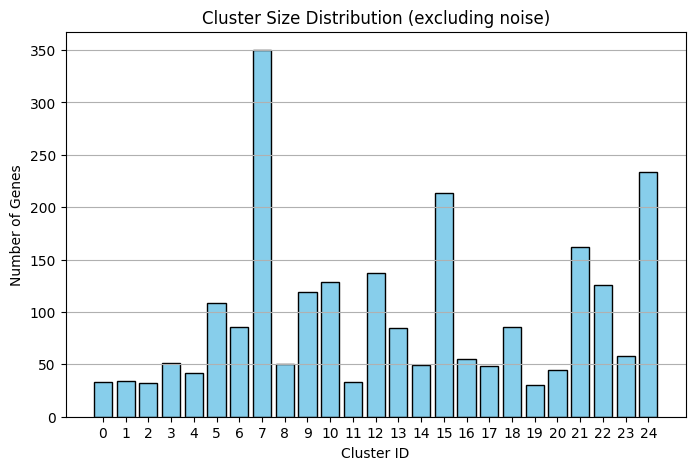

In [28]:
#grafico cluster size distribution
import matplotlib.pyplot as plt

def plot_cluster_size_distribution(labels):
    mask = labels != -1
    clusters, counts = np.unique(labels[mask], return_counts=True)

    plt.figure(figsize=(8, 5))
    plt.bar(clusters, counts, color='skyblue', edgecolor='black')
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Genes")
    plt.title("Cluster Size Distribution (excluding noise)")
    plt.xticks(clusters)
    plt.grid(axis='y')
    plt.show()
plot_cluster_size_distribution(labels)

Spectral Cluster


=== Spectral Clustering da W_fused ===
→ Numero cluster richiesti: 25
→ Clustering completato.
Cluster unici trovati: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


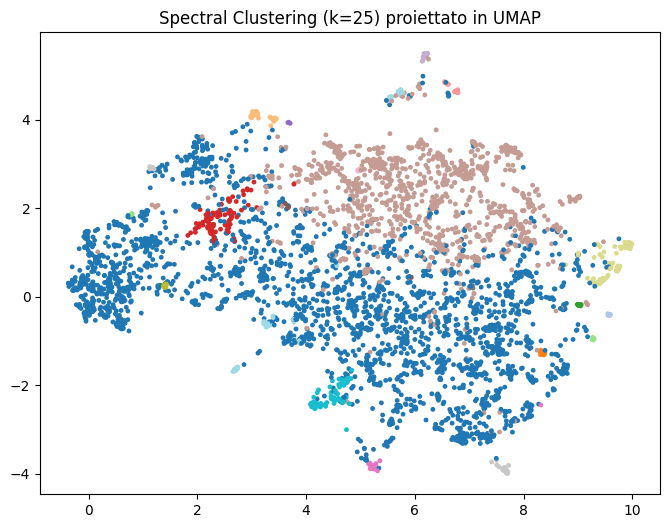


--- k = 5 ---
=== Spectral Clustering da W_fused ===
→ Numero cluster richiesti: 5
→ Clustering completato.
Cluster unici trovati: [0 1 2 3 4]


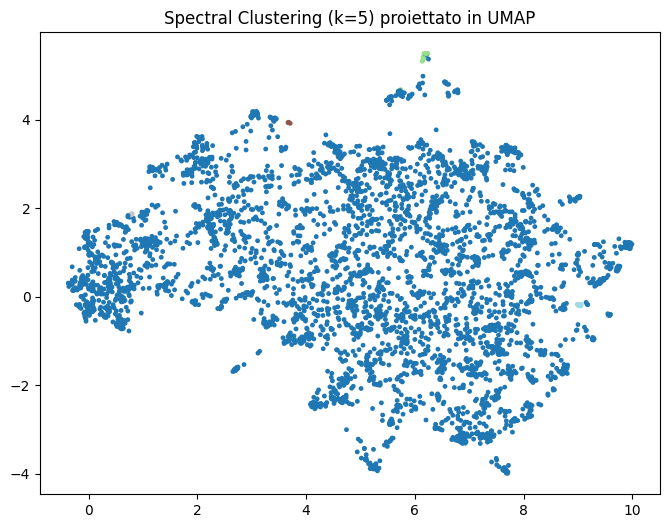


--- k = 8 ---
=== Spectral Clustering da W_fused ===
→ Numero cluster richiesti: 8
→ Clustering completato.
Cluster unici trovati: [0 1 2 3 4 5 6 7]


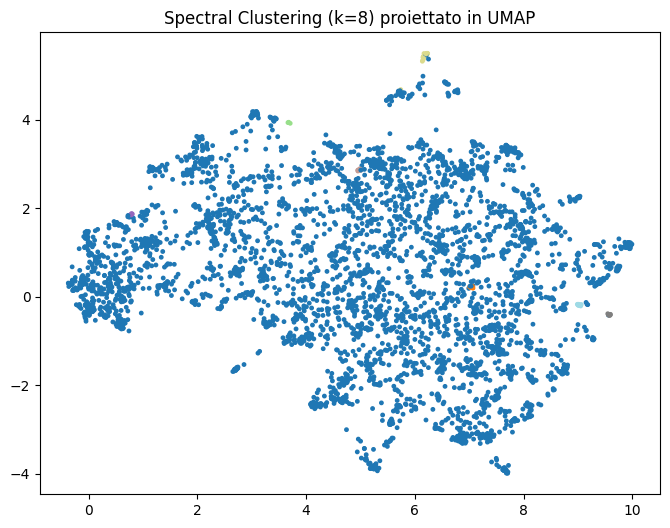


--- k = 10 ---
=== Spectral Clustering da W_fused ===
→ Numero cluster richiesti: 10
→ Clustering completato.
Cluster unici trovati: [0 1 2 3 4 5 6 7 8 9]


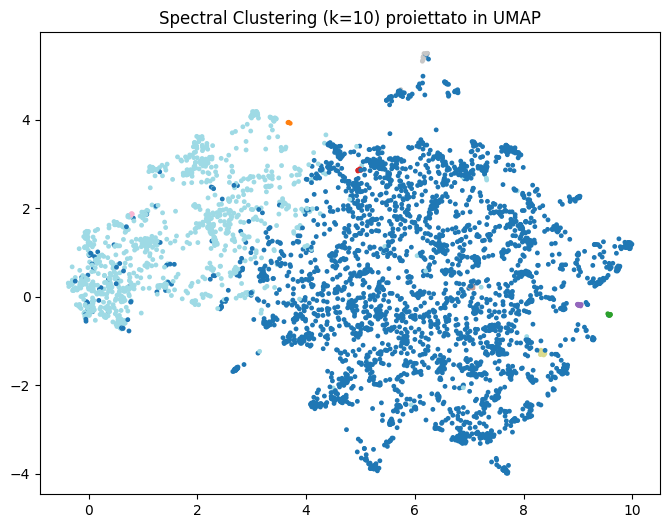


--- k = 15 ---
=== Spectral Clustering da W_fused ===
→ Numero cluster richiesti: 15
→ Clustering completato.
Cluster unici trovati: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


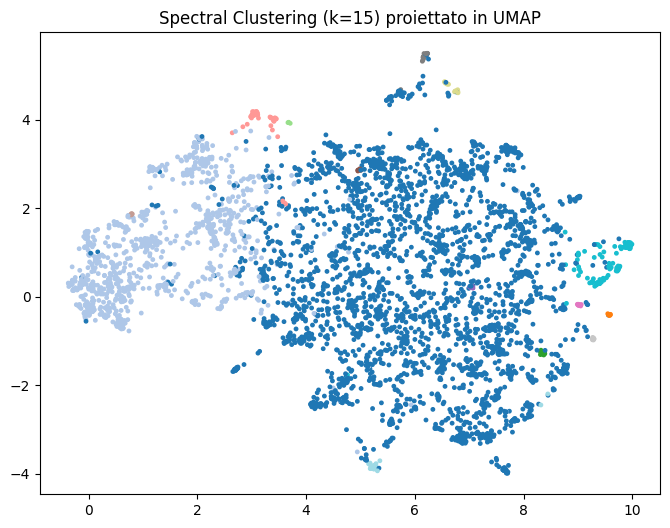

In [42]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import numpy as np

def run_spectral_clustering(W_fused, n_clusters=10, random_state=42, plot=True):
    """
    Esegue Spectral Clustering sulla matrice di affinità fusa (W_fused)
    e plottale etichette su UMAP.
    """
    print("=== Spectral Clustering da W_fused ===")
    print(f"→ Numero cluster richiesti: {n_clusters}")

    # Normalizzazione (opzionale, ma consigliata)
    W_norm = (W_fused - W_fused.min()) / (W_fused.max() - W_fused.min())

    model = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        assign_labels='kmeans',
        random_state=random_state
    )

    labels_spectral = model.fit_predict(W_norm)
    print("→ Clustering completato.")
    print(f"Cluster unici trovati: {np.unique(labels_spectral)}")

    # Plot su UMAP (se hai già la variabile embedding)
    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(embedding[:,0], embedding[:,1],
                    c=labels_spectral,
                    cmap='tab20', s=6)
        plt.title(f"Spectral Clustering (k={n_clusters}) proiettato in UMAP")
        plt.show()

    return labels_spectral

labels_spectral = run_spectral_clustering(W_fused, n_clusters=25)

for k in [5, 8, 10, 15]:
    print(f"\n--- k = {k} ---")
    labels_spectral = run_spectral_clustering(W_fused, n_clusters=k, plot=True)


# 9.Training MLP 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack

X_total = hstack([X_bp_tfidf, X_mf_tfidf, X_cc_tfidf]).tocsr()

mask = labels != -1
X_total = X_total[mask]
y = labels[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_total, y, test_size=0.2, random_state=42, stratify=y
)

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation="relu",
    solver="adam",
    batch_size=64,
    max_iter=200,
    random_state=42,
    verbose=True
)

mlp.fit(X_train, y_train)

pred = mlp.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))


Iteration 1, loss = 31.07416900
Iteration 2, loss = 26.15019442
Iteration 3, loss = 22.70055509
Iteration 4, loss = 18.09606718
Iteration 5, loss = 16.27582428
Iteration 6, loss = 15.28817788
Iteration 7, loss = 10.96868506
Iteration 8, loss = 8.44898625
Iteration 9, loss = 8.60364088
Iteration 10, loss = 7.47461698
Iteration 11, loss = 6.86053786
Iteration 12, loss = 6.93014767
Iteration 13, loss = 4.45238469
Iteration 14, loss = 2.20674463
Iteration 15, loss = 0.73563554
Iteration 16, loss = 0.89966035
Iteration 17, loss = 0.95000397
Iteration 18, loss = 2.18341233
Iteration 19, loss = 2.65721023
Iteration 20, loss = 4.82928828
Iteration 21, loss = 7.52378855
Iteration 22, loss = 6.62115462
Iteration 23, loss = 3.67955126
Iteration 24, loss = 1.18591814
Iteration 25, loss = 0.82947583
Iteration 26, loss = 0.67873645
Iteration 27, loss = 0.80214026
Iteration 28, loss = 0.88737510
Iteration 29, loss = 0.56780766
Iteration 30, loss = 0.60455798
Iteration 31, loss = 0.51007191
Iteration 

c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mlp = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # per sparse matrix
    ("clf", MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation="relu",
        solver="adam",
        batch_size=64,
        max_iter=200,
        random_state=42,
        verbose=True,
        alpha=1e-4,             # regularizzazione L2
        learning_rate_init=1e-3 # learning rate più stabile
    ))
])

mlp.fit(X_train, y_train)
MLPClassifier(..., early_stopping=True, n_iter_no_change=10)




Iteration 1, loss = 1.59260879
Iteration 2, loss = 0.10529963
Iteration 3, loss = 0.01787682
Iteration 4, loss = 0.00842424
Iteration 5, loss = 0.00528563
Iteration 6, loss = 0.00378307
Iteration 7, loss = 0.00289898
Iteration 8, loss = 0.00232750
Iteration 9, loss = 0.00195136
Iteration 10, loss = 0.00168022
Iteration 11, loss = 0.00147543
Iteration 12, loss = 0.00132556
Iteration 13, loss = 0.00120772
Iteration 14, loss = 0.00111048
Iteration 15, loss = 0.00103786
Iteration 16, loss = 0.00097407
Iteration 17, loss = 0.00092413
Iteration 18, loss = 0.00087690
Iteration 19, loss = 0.00083906
Iteration 20, loss = 0.00080696
Iteration 21, loss = 0.00078245
Iteration 22, loss = 0.00075654
Iteration 23, loss = 0.00073585
Iteration 24, loss = 0.00071639
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


,hidden_layer_sizes,Ellipsis
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,None


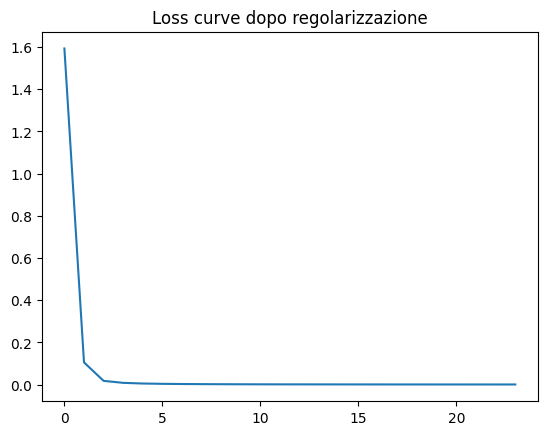

In [58]:
plt.plot(mlp.named_steps["clf"].loss_curve_)
plt.title("Loss curve dopo regolarizzazione")
plt.show()


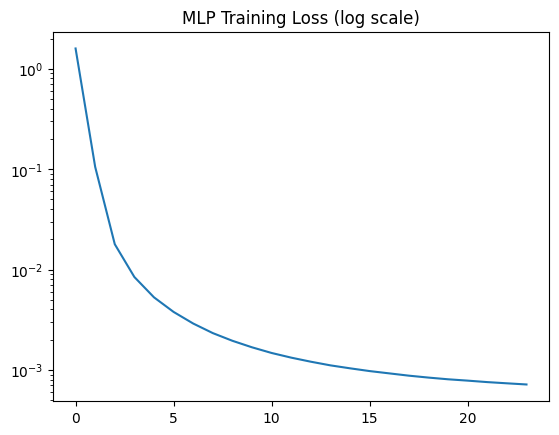

In [59]:
plt.plot(mlp.named_steps["clf"].loss_curve_)
plt.yscale("log")
plt.title("MLP Training Loss (log scale)")
plt.show()


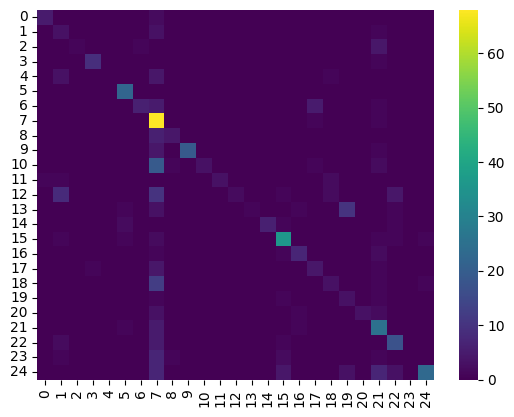

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=False, cmap="viridis")
plt.show()


In [61]:
for c in np.unique(y_test):
    m = y_test == c
    print(f"Cluster {c}: acc = {(pred[m]==y_test[m]).mean():.3f}")


Cluster 0: acc = 0.714
Cluster 1: acc = 0.429
Cluster 2: acc = 0.167
Cluster 3: acc = 0.900
Cluster 4: acc = 0.000
Cluster 5: acc = 1.000
Cluster 6: acc = 0.353
Cluster 7: acc = 0.971
Cluster 8: acc = 0.400
Cluster 9: acc = 0.792
Cluster 10: acc = 0.115
Cluster 11: acc = 0.429
Cluster 12: acc = 0.074
Cluster 13: acc = 0.059
Cluster 14: acc = 0.600
Cluster 15: acc = 0.837
Cluster 16: acc = 0.636
Cluster 17: acc = 0.400
Cluster 18: acc = 0.176
Cluster 19: acc = 0.500
Cluster 20: acc = 0.333
Cluster 21: acc = 0.781
Cluster 22: acc = 0.680
Cluster 23: acc = 0.000
Cluster 24: acc = 0.489


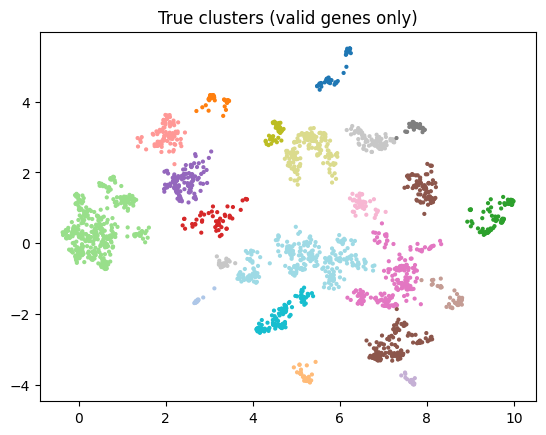

In [65]:
mask = labels != -1

embedding_valid = embedding[mask]
y_valid = labels[mask]

plt.scatter(
    embedding_valid[:,0], 
    embedding_valid[:,1],
    c=y_valid,
    cmap="tab20",
    s=4
)
plt.title("True clusters (valid genes only)")
plt.show()


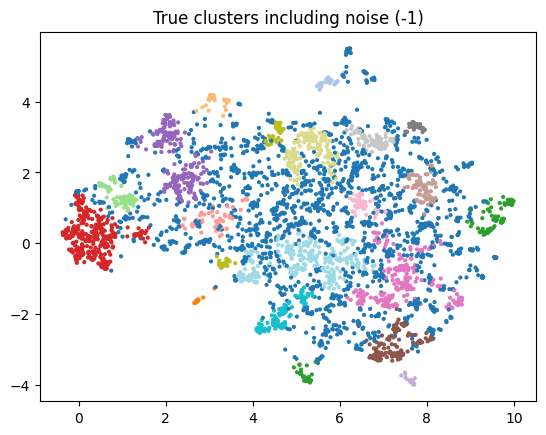

In [68]:
y_full = labels   # contiene anche -1

plt.scatter(
    embedding[:,0], 
    embedding[:,1],
    c=y_full,
    cmap="tab20",
    s=4
)
plt.title("True clusters including noise (-1)")
plt.show()


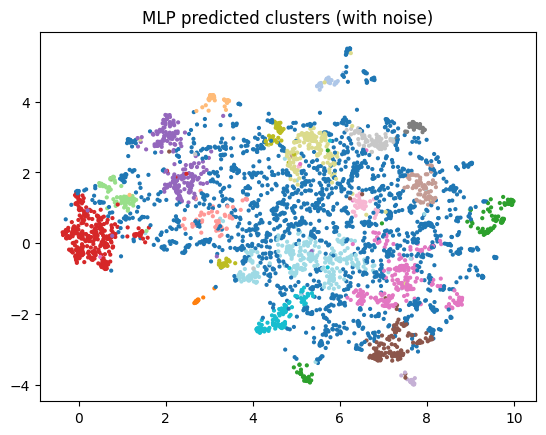

In [67]:
pred_full = np.full_like(labels, fill_value=-1)   # metto -1 per tutti
pred_full[mask] = mlp.predict(X_total)            # riempio solo i validi

plt.scatter(
    embedding[:,0],
    embedding[:,1],
    c=pred_full,
    cmap="tab20",
    s=4
)
plt.title("MLP predicted clusters (with noise)")
plt.show()


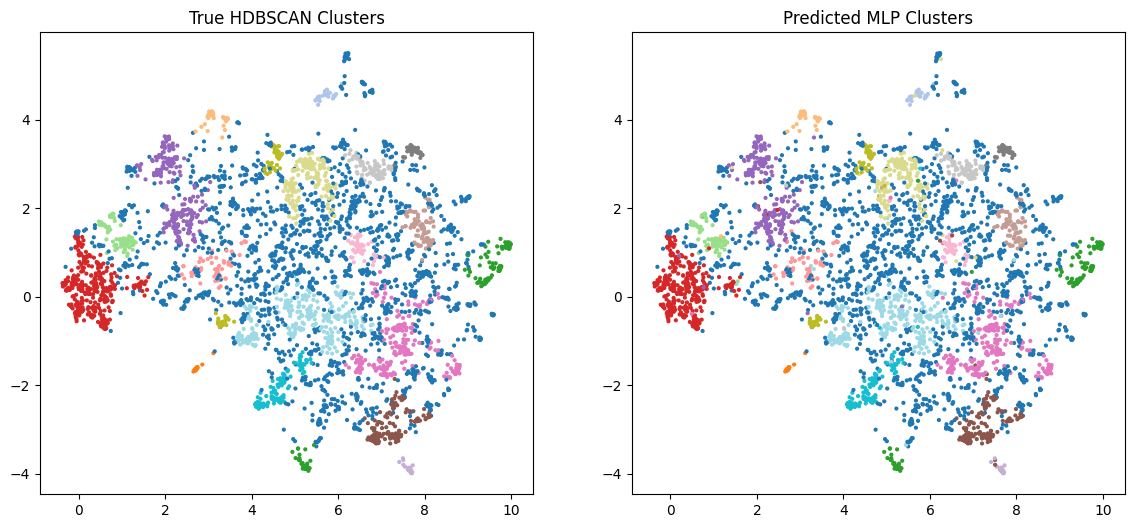

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# true clusters
ax[0].scatter(
    embedding[:,0], embedding[:,1],
    c=labels,
    cmap="tab20",
    s=4
)
ax[0].set_title("True HDBSCAN Clusters")

# predicted clusters
ax[1].scatter(
    embedding[:,0], embedding[:,1],
    c=pred_full,
    cmap="tab20",
    s=4
)
ax[1].set_title("Predicted MLP Clusters")

plt.show()
